# **Youtube Videos Transcription with OpenAI's Whisper**

[![blog post shield](https://img.shields.io/static/v1?label=&message=Blog%20post&color=blue&style=for-the-badge&logo=openai&link=https://openai.com/blog/whisper)](https://openai.com/blog/whisper)
[![notebook shield](https://img.shields.io/static/v1?label=&message=Notebook&color=blue&style=for-the-badge&logo=googlecolab&link=https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)](https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)
[![repository shield](https://img.shields.io/static/v1?label=&message=Repository&color=blue&style=for-the-badge&logo=github&link=https://github.com/openai/whisper)](https://github.com/openai/whisper)
[![paper shield](https://img.shields.io/static/v1?label=&message=Paper&color=blue&style=for-the-badge&link=https://cdn.openai.com/papers/whisper.pdf)](https://cdn.openai.com/papers/whisper.pdf)
[![model card shield](https://img.shields.io/static/v1?label=&message=Model%20card&color=blue&style=for-the-badge&link=https://github.com/openai/whisper/blob/main/model-card.md)](https://github.com/openai/whisper/blob/main/model-card.md)

Whisper is a general-purpose speech recognition model. It is trained on a large dataset of diverse audio and is also a multi-task model that can perform multilingual speech recognition as well as speech translation and language identification.

This Notebook will guide you through the transcription of a Youtube video using Whisper. You'll be able to explore most inference parameters or use the Notebook as-is to store the transcript and video audio in your Google Drive.

In [ ]:
#@markdown # **Check GPU type** 🕵️

#@markdown The type of GPU you get assigned in your Colab session defined the speed at which the video will be transcribed.
#@markdown The higher the number of floating point operations per second (FLOPS), the faster the transcription.
#@markdown But even the least powerful GPU available in Colab is able to run any Whisper model.
#@markdown Make sure you've selected `GPU` as hardware accelerator for the Notebook (Runtime &rarr; Change runtime type &rarr; Hardware accelerator).

#@markdown |  GPU   |  GPU RAM   | FP32 teraFLOPS |     Availability   |
#@markdown |:------:|:----------:|:--------------:|:------------------:|
#@markdown |  T4    |    16 GB   |       8.1      |         Free       |
#@markdown | P100   |    16 GB   |      10.6      |      Colab Pro     |
#@markdown | V100   |    16 GB   |      15.7      |  Colab Pro (Rare)  |

#@markdown ---
#@markdown **Factory reset your Notebook's runtime if you want to get assigned a new GPU.**

!nvidia-smi -L

!nvidia-smi

In [1]:
#@markdown # **Install libraries** 🏗️
#@markdown This cell will take a little while to download several libraries, including Whisper.

#@markdown ---

! pip install git+https://github.com/openai/whisper.git
! pip install pytube

import sys
import warnings
import whisper
from pathlib import Path
import pytube
import subprocess
import torch
import shutil
import numpy as np
from IPython.display import display, Markdown, YouTubeVideo

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-hm221goh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-hm221goh
  Resolved https://github.com/openai/whisper.git to commit ad3250a846fe7553a25064a2dc593e492dadf040
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.9 MB/s eta 0:00:00
  Created wheel for ope

Using device: cuda:0


In [ ]:
#@markdown # **Optional:** Save data in Google Drive 💾
#@markdown Enter a Google Drive path and run this cell if you want to store the results inside Google Drive.

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "My Drive"
#@markdown ---
drive_path = "Colab Notebooks/Whisper Youtube" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change your Google Drive path.**

drive_whisper_path = drive_mount_path / Path(drive_path.lstrip("/"))
drive_whisper_path.mkdir(parents=True, exist_ok=True)

In [2]:
#@markdown # **Model selection** 🧠

#@markdown As of the first public release, there are 4 pre-trained options to play with:

#@markdown |  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
#@markdown |:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
#@markdown |  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
#@markdown |  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
#@markdown | small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
#@markdown | medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
#@markdown | large  |   1550 M   |        N/A         |      `large`       |    ~10 GB     |       1x       |

#@markdown ---
Model = 'large' #@param ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']
#@markdown ---
#@markdown **Run this cell again if you change the model.**

whisper_model = whisper.load_model(Model)

if Model in whisper.available_models():
    display(Markdown(
        f"**{Model} model is selected.**"
    ))
else:
    display(Markdown(
        f"**{Model} model is no longer available.**<br /> Please select one of the following:<br /> - {'<br /> - '.join(whisper.available_models())}"
    ))

100%|██████████████████████████████████████| 2.87G/2.87G [00:17<00:00, 177MiB/s]


**large model is selected.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
https://i.imgur.com/eEpRFST.png

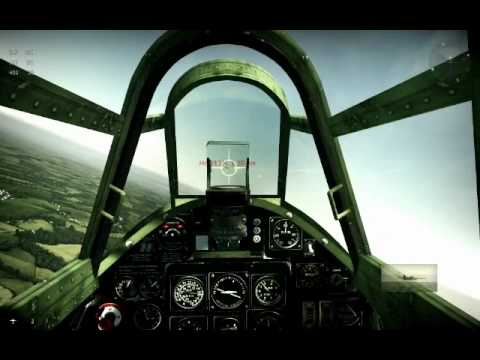

In [6]:
#@markdown # **Video selection** 📺

#@markdown Enter the URL of the Youtube video you want to transcribe, wether you want to save the audio file in your Google Drive, and run the cell.

Type = "Youtube video or playlist" #@param ['Youtube video or playlist', 'Google Drive']
#@markdown ---
#@markdown #### **Youtube video or playlist**
URL = "https://youtu.be/QxWFe686FGI" #@param {type:"string"}
store_audio = True #@param {type:"boolean"}
#@markdown ---
#@markdown #### **Google Drive video, audio (mp4, wav), or folder containing video and/or audio files**
video_path = "/content/drive/MyDrive/\u041B\u0443\u0447\u0448\u0430\u044F \u044D\u041D\u0424\u044D\u044D\u0421\u043A\u0430 \u0437\u0430 \u0432\u0441\u0435 \u0432\u0440\u0435\u043C\u044F - Porsche Unleashed.mp4" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change the video.**
drive_whisper_path = "/content/drive/MyDrive/Whisper"
video_path_local_list = []

if Type == "Youtube video or playlist":
    
    try:
        list_video_yt = [pytube.YouTube(URL)]
    except Exception:
        try:
            list_video_yt = list(pytube.Playlist(URL).videos)
        except Exception:
            raise(RuntimeError(f"{URL} isn't recgnized."))
    
    for video_yt in list_video_yt:
        try:
            video_yt.check_availability()
            display(
                YouTubeVideo(video_yt.video_id)
            )
        except pytube.exceptions.VideoUnavailable:
            display(
                Markdown(f"**{URL} isn't available.**"),
            )
            raise(RuntimeError(f"{URL} isn't available."))
        video_path_local = Path(".").resolve() / (video_yt.video_id+".mp4")
        video_yt.streams.filter(
            type="audio",
            mime_type="audio/mp4",
            abr="48kbps"
        ).first().download(
            output_path = video_path_local.parent,
            filename = video_path_local.name
        )
        if store_audio:
            shutil.copy(video_path_local, Path(drive_whisper_path) / video_path_local.name)
        video_path_local_list.append(video_path_local)

elif Type == "Google Drive":
    # video_path_drive = drive_mount_path / Path(video_path.lstrip("/"))
    for video_path_drive in (drive_mount_path / Path(video_path.lstrip("/"))).glob("**/*"):
        video_path_local = Path(".").resolve() / (video_path_drive.name)
        shutil.copy(video_path_drive, video_path_local)
        if video_path_drive.is_file():
            display(Markdown(f"**{str(video_path_drive)} selected for transcription.**"))
        else:
            display(Markdown(f"**{str(video_path_drive)} does not exists.**"))
            raise(RuntimeError(f"{str(video_path_drive)} does not exists."))
        video_path_local_list.append(video_path_local)
else:
    raise(TypeError("Please select supported input type."))

for video_path_local in video_path_local_list:
    if video_path_local.suffix == ".mp4":
        video_path_local = video_path_local.with_suffix(".wav")
        result  = subprocess.run(["ffmpeg", "-i", str(video_path_local.with_suffix(".mp4")), "-vn", "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1", str(video_path_local)])


In [7]:
#@markdown # **Run the model** 🚀

#@markdown Run this cell to execute the transcription of the video. This can take a while and very based on the length of the video and the number of parameters of the model selected above.

#@markdown ## **Parameters** ⚙️

#@markdown ### **Behavior control**
#@markdown ---
language = "Russian" #@param ['Auto detection', 'Afrikaans', 'Albanian', 'Amharic', 'Arabic', 'Armenian', 'Assamese', 'Azerbaijani', 'Bashkir', 'Basque', 'Belarusian', 'Bengali', 'Bosnian', 'Breton', 'Bulgarian', 'Burmese', 'Castilian', 'Catalan', 'Chinese', 'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Faroese', 'Finnish', 'Flemish', 'French', 'Galician', 'Georgian', 'German', 'Greek', 'Gujarati', 'Haitian', 'Haitian Creole', 'Hausa', 'Hawaiian', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Javanese', 'Kannada', 'Kazakh', 'Khmer', 'Korean', 'Lao', 'Latin', 'Latvian', 'Letzeburgesch', 'Lingala', 'Lithuanian', 'Luxembourgish', 'Macedonian', 'Malagasy', 'Malay', 'Malayalam', 'Maltese', 'Maori', 'Marathi', 'Moldavian', 'Moldovan', 'Mongolian', 'Myanmar', 'Nepali', 'Norwegian', 'Nynorsk', 'Occitan', 'Panjabi', 'Pashto', 'Persian', 'Polish', 'Portuguese', 'Punjabi', 'Pushto', 'Romanian', 'Russian', 'Sanskrit', 'Serbian', 'Shona', 'Sindhi', 'Sinhala', 'Sinhalese', 'Slovak', 'Slovenian', 'Somali', 'Spanish', 'Sundanese', 'Swahili', 'Swedish', 'Tagalog', 'Tajik', 'Tamil', 'Tatar', 'Telugu', 'Thai', 'Tibetan', 'Turkish', 'Turkmen', 'Ukrainian', 'Urdu', 'Uzbek', 'Valencian', 'Vietnamese', 'Welsh', 'Yiddish', 'Yoruba']
#@markdown > Language spoken in the audio, use `Auto detection` to let Whisper detect the language.
#@markdown ---
verbose = 'Live transcription' #@param ['Live transcription', 'Progress bar', 'None']
#@markdown > Whether to print out the progress and debug messages.
#@markdown ---
output_format = 'srt' #@param ['txt', 'vtt', 'srt', 'tsv', 'json', 'all']
#@markdown > Type of file to generate to record the transcription.
#@markdown ---
task = 'transcribe' #@param ['transcribe', 'translate']
#@markdown > Whether to perform X->X speech recognition (`transcribe`) or X->English translation (`translate`).
#@markdown ---

#@markdown <br/>

#@markdown ### **Optional: Fine tunning** 
#@markdown ---
temperature = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
#@markdown > Temperature to use for sampling.
#@markdown ---
temperature_increment_on_fallback = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}
#@markdown > Temperature to increase when falling back when the decoding fails to meet either of the thresholds below.
#@markdown ---
best_of = 5 #@param {type:"integer"}
#@markdown > Number of candidates when sampling with non-zero temperature.
#@markdown ---
beam_size = 8 #@param {type:"integer"}
#@markdown > Number of beams in beam search, only applicable when temperature is zero.
#@markdown ---
patience = 1.0 #@param {type:"number"}
#@markdown > Optional patience value to use in beam decoding, as in [*Beam Decoding with Controlled Patience*](https://arxiv.org/abs/2204.05424), the default (1.0) is equivalent to conventional beam search.
#@markdown ---
length_penalty = -0.05 #@param {type:"slider", min:-0.05, max:1, step:0.05}
#@markdown > Optional token length penalty coefficient (alpha) as in [*Google's Neural Machine Translation System*](https://arxiv.org/abs/1609.08144), set to negative value to uses simple length normalization.
#@markdown ---
suppress_tokens = "-1" #@param {type:"string"}
#@markdown > Comma-separated list of token ids to suppress during sampling; '-1' will suppress most special characters except common punctuations.
#@markdown ---
initial_prompt = "" #@param {type:"string"}
#@markdown > Optional text to provide as a prompt for the first window.
#@markdown ---
condition_on_previous_text = True #@param {type:"boolean"}
#@markdown > if True, provide the previous output of the model as a prompt for the next window; disabling may make the text inconsistent across windows, but the model becomes less prone to getting stuck in a failure loop.
#@markdown ---
fp16 = True #@param {type:"boolean"}
#@markdown > whether to perform inference in fp16.
#@markdown ---
compression_ratio_threshold = 2.4 #@param {type:"number"}
#@markdown > If the gzip compression ratio is higher than this value, treat the decoding as failed.
#@markdown ---
logprob_threshold = -1.0 #@param {type:"number"}
#@markdown > If the average log probability is lower than this value, treat the decoding as failed.
#@markdown ---
no_speech_threshold = 0.6 #@param {type:"slider", min:-0.0, max:1, step:0.05}
#@markdown > If the probability of the <|nospeech|> token is higher than this value AND the decoding has failed due to `logprob_threshold`, consider the segment as silence.
#@markdown ---

verbose_lut = {
    'Live transcription': True,
    'Progress bar': False,
    'None': None
}

args = dict(
    language = (None if language == "Auto detection" else language),
    verbose = verbose_lut[verbose],
    task = task,
    temperature = temperature,
    temperature_increment_on_fallback = temperature_increment_on_fallback,
    best_of = best_of,
    beam_size = beam_size,
    patience=patience,
    length_penalty=(length_penalty if length_penalty>=0.0 else None),
    suppress_tokens=suppress_tokens,
    initial_prompt=(None if not initial_prompt else initial_prompt),
    condition_on_previous_text=condition_on_previous_text,
    fp16=fp16,
    compression_ratio_threshold=compression_ratio_threshold,
    logprob_threshold=logprob_threshold,
    no_speech_threshold=no_speech_threshold
)

temperature = args.pop("temperature")
temperature_increment_on_fallback = args.pop("temperature_increment_on_fallback")
if temperature_increment_on_fallback is not None:
    temperature = tuple(np.arange(temperature, 1.0 + 1e-6, temperature_increment_on_fallback))
else:
    temperature = [temperature]

if Model.endswith(".en") and args["language"] not in {"en", "English"}:
    warnings.warn(f"{Model} is an English-only model but receipted '{args['language']}'; using English instead.")
    args["language"] = "en"

for video_path_local in video_path_local_list:
    display(Markdown(f"### {video_path_local}"))

    video_transcription = whisper.transcribe(
        whisper_model,
        str(video_path_local),
        temperature=temperature,
        **args,
    )

    # Save output
    whisper.utils.get_writer(
        output_format=output_format,
        output_dir=video_path_local.parent
    )(
        video_transcription,
        str(video_path_local.stem)
    )
    try:
        if output_format=="all":
            for ext in ('txt', 'vtt', 'srt', 'tsv', 'json'):
                transcript_file_name = video_path_local.stem + "." + ext
                shutil.copy(
                    video_path_local.parent / transcript_file_name,
                    drive_whisper_path / transcript_file_name
                )
                display(Markdown(f"**Transcript file created: {drive_whisper_path / transcript_file_name}**"))
        else:
            transcript_file_name = video_path_local.stem + "." + output_format
            shutil.copy(
                video_path_local.parent / transcript_file_name,
                drive_whisper_path / transcript_file_name
            )
            display(Markdown(f"**Transcript file created: {drive_whisper_path / transcript_file_name}**"))

    except:
        display(Markdown(f"**Transcript file created: {transcript_local_path}**"))

### /content/QxWFe686FGI.mp4

[00:00.000 --> 00:05.000]  начинается все со взлета с аэродрома
[00:05.000 --> 00:09.000]  тут все просто, надо раскрутить двигатель
[00:09.000 --> 00:12.000]  а потом куда он поедет
[00:12.000 --> 00:15.000]  тупо на себя
[00:15.000 --> 00:20.000]  руль или рычаг, как он там называют, штурвал
[00:20.000 --> 00:23.000]  натянуть, а потом убрать шасси
[00:23.000 --> 00:28.000]  это же графика очень приятная, современная
[00:29.000 --> 00:32.000]  кабина высоко детализирована
[00:32.000 --> 00:36.000]  даже вроде динамическое освещение есть
[00:36.000 --> 00:40.000]  можно осматриваться по сторонам
[00:40.000 --> 00:43.000]  стрелять
[00:58.000 --> 01:03.000]  очень красиво, гармонично
[01:18.000 --> 01:21.000]  можно пролететь пониже
[01:21.000 --> 01:24.000]  над землей, так сказать
[01:28.000 --> 01:31.000]  вообще классно
[01:47.000 --> 01:50.000]  конечно, чтобы тут стрелять и все такое
[01:50.000 --> 01:54.000]  то надо дрочиться очень нехило
[01:54.000 --> 01:58.000]  помню в X-3 

NameError: ignored